In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
import timm

warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

def set_seed(seed=0):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    
set_seed(7777)

In [3]:
import pretrainedmodels

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device를 cuda로 설정
print(device)

cuda


### Data overview

In [5]:
train_df = pd.read_csv("train.csv")
train_df = train_df[train_df['Id'] != 'new_whale']
train_df.reset_index(drop=True)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9035,ffe5c306.jpg,w_2ceab05
9036,ffeaa7a4.jpg,w_b067417
9037,ffecec63.jpg,w_8b56cb1
9038,fff04277.jpg,w_2dcbf82


In [6]:
# class_counts = train_df['Id'].value_counts()

# # 데이터 개수가 1인 클래스를 찾습니다.
# single_count_classes = class_counts[class_counts == 1].index

# # 클래스별 데이터 개수가 1인 행을 제거합니다.
# filtered_train_df = train_df[~train_df['Id'].isin(single_count_classes)]

# filtered_train_df.reset_index(drop=True)
# train_df = filtered_train_df

In [7]:
len(train_df)

9040

For train data we have a DataFrame with image names and ids. And of course for train and test we have images in separate folders.

In [8]:
print(f"There are {len(os.listdir('train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('test'))} images in test dataset.")

There are 9850 images in train dataset with 4250 unique classes.
There are 15610 images in test dataset.


25k images in train and 5k different whales!
Let's have a look at them

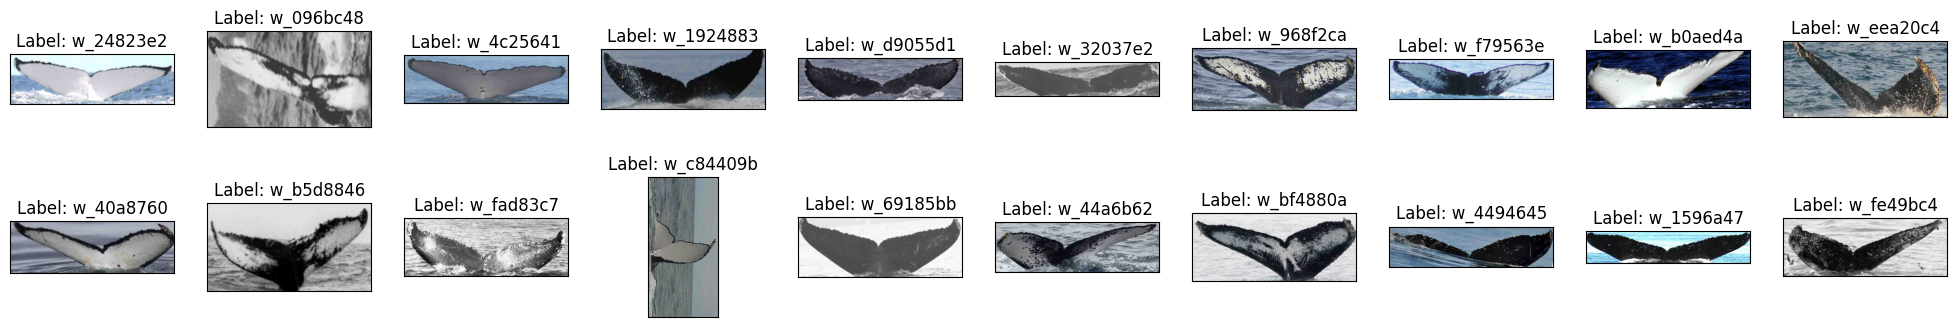

In [9]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("whale/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [10]:
train_df.Id.value_counts()

w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_693c9ee    22
             ..
w_6f504c0     1
w_2fdee7b     1
w_a0838d1     1
w_3698eaf     1
w_b9bfd4e     1
Name: Id, Length: 4250, dtype: int64

In [11]:
len(train_df['Id'].unique())

4250

In [12]:
train_df[train_df['Id'] == 'new_whale']

,Image,Id


In [13]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


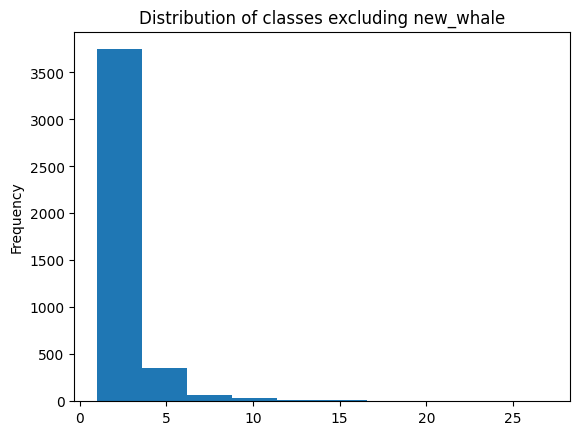

In [14]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

We can see that there is a huge disbalance in the data. There are many classes with only one or several samples , some classes have 50+ samples and "default" class has almost 10k samples.

## Dataset

Now we need to create a dataset. Sadly, default version won't work, as images for each class are supposed to be in separate folders. So I write a custom WhaleDataset.

In [18]:
from itertools import combinations
import random

class TripletGenerator:
    def __init__(self, file_class_mapping):
        self.file_class_mapping = file_class_mapping
        self.class_to_files = defaultdict(list)

        for file, class_ in file_class_mapping.items():
            self.class_to_files[class_].append(file)

        self.classes = list(self.class_to_files.keys())

    def get_triplet(self):
        pos_class = random.choice(self.classes)
        pos_files = self.class_to_files[pos_class]

        # Anchor, Positive 선택
        if len(pos_files) > 1:
            anchor, positive = random.sample(pos_files, 2)
        else:
            anchor = positive = pos_files[0]

        # Negative 선택
        neg_class = random.choice([cls for cls in self.classes if cls != pos_class])
        negative = random.choice(self.class_to_files[neg_class])

        return anchor, positive, negative

In [19]:
class TripletWhaleDataset(Dataset):
    def __init__(self, datafolder, df, triplet_gen, transform=None):
        self.datafolder = datafolder
        self.df = df.values
        self.triplet_gen = triplet_gen
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_path, positive_path, negative_path = self.triplet_gen.get_triplet()
        anchor = self.read_image(anchor_path)
        positive = self.read_image(positive_path)
        negative = self.read_image(negative_path)

        return anchor, positive, negative, anchor_path, positive_path, negative_path

    def read_image(self, path):
        img_name = os.path.join(self.datafolder, path)
        image = np.array(Image.open(img_name).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image

In [16]:
data_transforms = A.Compose([
                            A.Resize(224, 224),
                            A.HorizontalFlip(p=0.5),
                            A.OneOf([
                                A.CLAHE(clip_limit=0.2, tile_grid_size=(3, 3), p=0.7),
                                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5)
                            ], p=0.5),                            
                            A.Rotate(limit=15, p=0.5),
                            A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                            A.ToGray(p=0.5),
                            ToTensorV2()
])

data_transforms_test = A.Compose([
                                   A.Resize(224, 224),
                                   A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                                   # A.ToGray(p=1),
                                   ToTensorV2()
])

In [21]:
file_class_mapping = {row['Image']: row['Id'] for index, row in train_df.iterrows()}

In [22]:
triplet_gen = TripletGenerator(file_class_mapping)
dataset = TripletWhaleDataset('whale/', train_df, triplet_gen, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

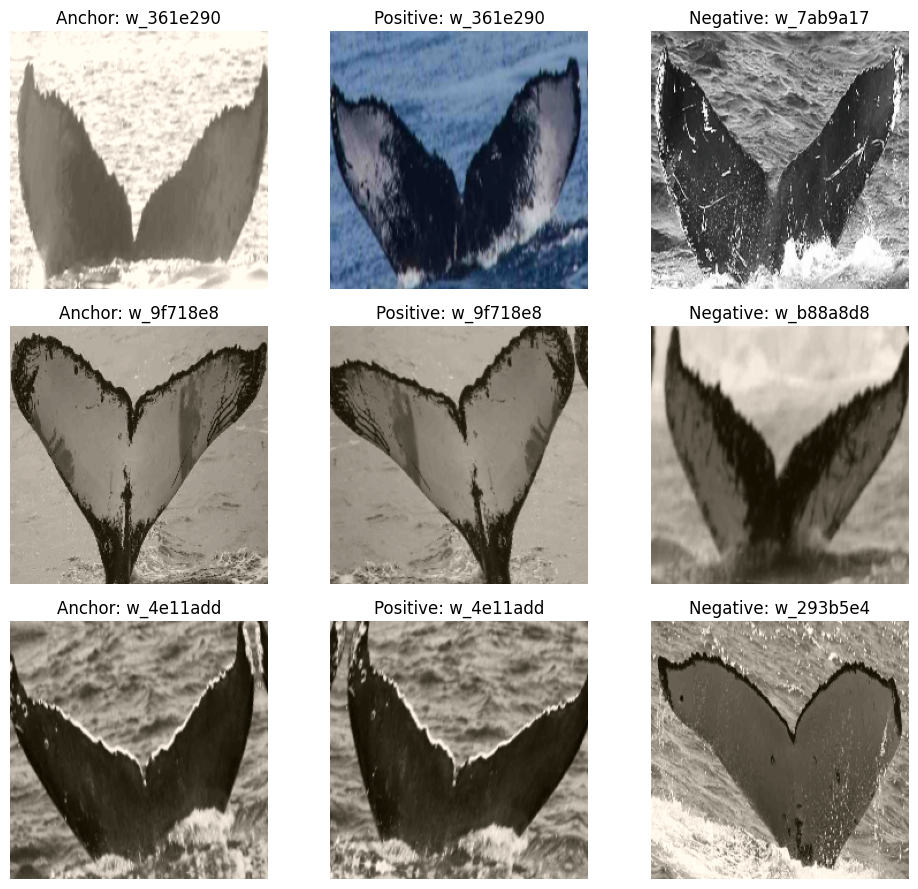

In [24]:
anchor, positive, negative, anchor_path, positive_path, negative_path = next(iter(dataloader))
fig, axes = plt.subplots(3, 3, figsize=(10, 9))

MEAN = np.array([0.485 , 0.456, 0.406])
STD = np.array([0.229, 0.224 , 0.225])
    
for i in range(3):
    img = anchor[i] * STD[:, None, None] + MEAN[:, None, None]
    axes[i, 0].imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1))
    axes[i, 0].set_title(f"Anchor: {train_df.loc[train_df['Image'] == anchor_path[i], 'Id'].values[0]}")
    axes[i, 0].axis('off')

    # 두 번째 열에 positive 이미지와 제목 추가
    img = positive[i] * STD[:, None, None] + MEAN[:, None, None]
    axes[i, 1].imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1))
    axes[i, 1].set_title(f"Positive: {train_df.loc[train_df['Image'] == positive_path[i], 'Id'].values[0]}")
    axes[i, 1].axis('off')

    # 세 번째 열에 negative 이미지와 제목 추가
    img = negative[i] * STD[:, None, None] + MEAN[:, None, None]
    axes[i, 2].imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1))
    axes[i, 2].set_title(f"Negative: {train_df.loc[train_df['Image'] == negative_path[i], 'Id'].values[0]}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Initializing model

We need to define model, loss, oprimizer and possibly a scheduler.

In [29]:
import torch
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive, 2)
        negative_distance = F.pairwise_distance(anchor, negative, 2)

        loss = torch.mean(torch.clamp(positive_distance - negative_distance + self.margin, min=0.0))
        return loss

In [115]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)
    
model = SiameseNetwork().to(device)
criterion = TripletLoss(margin=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

C:\Users\MMC_JYB\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MMC_JYB\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# class TripletMarginWithDistanceLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletMarginWithDistanceLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         distance_positive = torch.norm(anchor - positive, p=2, dim=1)
#         distance_negative = torch.norm(anchor - negative, p=2, dim=1)
#         loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0)
#         return loss.mean()
    
# triplet_loss = nn.T ripletMarginLoss(margin=1.0, p=2)
# # triplet_loss = TripletMarginWithDistanceLoss(margin=1.0)
# model = SiameseNetwork().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, min_lr=1e-6)

In [31]:
def train(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch+1}/{epochs}')
        for i, data in progress_bar:
            anchor, positive, negative, _, _, _ = data
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.8f}")
        torch.save(model, f'model_triplet.pth')
        
train(model, dataloader, 10)

Epoch 1/10: 100%|██████████| 283/283 [04:53<00:00,  1.04s/it, loss=0.171]


Epoch 1, Loss: 0.17088732


Epoch 2/10: 100%|██████████| 283/283 [04:43<00:00,  1.00s/it, loss=0.083] 


Epoch 2, Loss: 0.08303000


Epoch 3/10: 100%|██████████| 283/283 [04:42<00:00,  1.00it/s, loss=0.0681]


Epoch 3, Loss: 0.06812168


Epoch 4/10: 100%|██████████| 283/283 [04:42<00:00,  1.00it/s, loss=0.0627]


Epoch 4, Loss: 0.06267840


Epoch 5/10: 100%|██████████| 283/283 [04:42<00:00,  1.00it/s, loss=0.058] 


Epoch 5, Loss: 0.05795349


Epoch 6/10: 100%|██████████| 283/283 [04:42<00:00,  1.00it/s, loss=0.0616]


Epoch 6, Loss: 0.06161081


Epoch 7/10: 100%|██████████| 283/283 [04:41<00:00,  1.00it/s, loss=0.059] 


Epoch 7, Loss: 0.05898286


Epoch 8/10: 100%|██████████| 283/283 [04:42<00:00,  1.00it/s, loss=0.0521]


Epoch 8, Loss: 0.05209270


Epoch 9/10: 100%|██████████| 283/283 [04:41<00:00,  1.00it/s, loss=0.0506]


Epoch 9, Loss: 0.05059127


Epoch 10/10: 100%|██████████| 283/283 [04:41<00:00,  1.01it/s, loss=0.0494]

Epoch 10, Loss: 0.04941638


## Inference

In [24]:
# model_conv.load_state_dict(torch.load('model_5.pth'))

In [32]:
# class CustomDataset(Dataset):
#     def __init__(self, datafolder, transform=None):
#         self.datafolder = datafolder
#         self.image_files_list = [s for s in os.listdir(datafolder)]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_files_list)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.datafolder, self.image_files_list[idx])
#         image = np.array(Image.open(img_name).convert('RGB'))
#         if self.transform:
#             image = self.transform(image=image)["image"]
#         return image, self.image_files_list[idx]

# train_dataset = CustomDataset('whale/', transform=data_transforms)
# test_dataset = CustomDataset('test_yolo/', transform=data_transforms_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, datafolder, dataframe=None, transform=None, is_train=True):
        self.datafolder = datafolder
        self.transform = transform
        self.is_train = is_train

        if self.is_train:
            # Train 데이터셋의 경우 DataFrame에서 파일 이름을 가져옴
            self.image_files_list = [os.path.join(datafolder, fname) for fname in dataframe['Image']]
        else:
            # Test 데이터셋의 경우 디렉토리 내의 모든 파일을 사용
            self.image_files_list = [os.path.join(datafolder, s) for s in os.listdir(datafolder)]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        image = np.array(Image.open(img_name).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, os.path.basename(img_name)

# 데이터셋 객체 생성
train_dataset = CustomDataset('whale/', train_df, transform=data_transforms_test, is_train=True)
test_dataset = CustomDataset('test_yolo/', transform=data_transforms_test, is_train=False)

# DataLoader 객체 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    file_names = []
    with torch.no_grad():
        for imgs, fpaths in tqdm.tqdm(dataloader):
            imgs = imgs.to(device)
            emb = model(imgs)
            embeddings.append(emb.cpu().numpy())
            file_names.extend(fpaths)
    return np.concatenate(embeddings), file_names

# 임베딩 추출
train_embeddings, train_fnames = extract_embeddings(train_loader, model)
test_embeddings, test_fnames = extract_embeddings(test_loader, model)

100%|██████████| 488/488 [01:52<00:00,  4.35it/s]


In [112]:
class SemiHardTripletDataset(Dataset):
    def __init__(self, datafolder, file_class_mapping, embeddings, labels, transform=None, margin=0.2):
        self.datafolder = datafolder
        self.file_class_mapping = file_class_mapping
        self.embeddings = embeddings
        self.labels = labels
        self.transform = transform
        self.margin = margin

        self.class_to_files = defaultdict(list)
        for file, class_ in file_class_mapping.items():
            self.class_to_files[class_].append(file)

        self.classes = list(self.class_to_files.keys())

    def get_semi_hard_negative(self, anchor_idx, pos_idx):
        anchor_emb = self.embeddings[anchor_idx]
        positive_emb = self.embeddings[pos_idx]
        dist_anchor_positive = np.linalg.norm(anchor_emb - positive_emb)

        negative_indices = np.where(self.labels != self.labels[anchor_idx])[0]
        semi_hard_negatives = []
        for neg_idx in negative_indices:
            dist_anchor_negative = np.linalg.norm(anchor_emb - self.embeddings[neg_idx])
            if dist_anchor_positive < dist_anchor_negative < dist_anchor_positive + self.margin:
                semi_hard_negatives.append(neg_idx)

        return random.choice(semi_hard_negatives) if semi_hard_negatives else random.choice(negative_indices)

    def __getitem__(self, idx):
        anchor_file = list(self.file_class_mapping.keys())[idx]
        pos_file = random.choice(self.class_to_files[self.file_class_mapping[anchor_file]])

        neg_idx = self.get_semi_hard_negative(idx, list(self.file_class_mapping.keys()).index(pos_file))
        neg_file = list(self.file_class_mapping.keys())[neg_idx]

        anchor_img = self.read_image(anchor_file)
        pos_img = self.read_image(pos_file)
        neg_img = self.read_image(neg_file)

        return anchor_img, pos_img, neg_img

    def __len__(self):
        return len(self.file_class_mapping)

    def read_image(self, file_name):
        img_path = os.path.join(self.datafolder, file_name)
        image = np.array(Image.open(img_path).convert('RGB'))
        return self.transform(image=image)["image"] if self.transform else image

In [113]:
dataset = SemiHardTripletDataset('./whale/', file_class_mapping, train_embeddings, train_fnames, data_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def train(model, dataloader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch+1}/{epochs}')
        for i, data in progress_bar:
            anchor, positive, negative = data
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.8f}")
        torch.save(model, f'model_triplet_after.pth')
        
train(model, dataloader, 15)

In [37]:
# from sklearn.neighbors import NearestNeighbors

# neigh = NearestNeighbors(n_neighbors=5)
# neigh.fit(train_embeddings)

# distances_test, neighbors_test = neigh.kneighbors(test_embeddings)

# file_id_mapping = {k: v for k, v in zip(train_df.Image.values, train_df.Id.values)}

# preds_str = []
# for fpath, (distances, neighbors) in zip(test_fnames, zip(distances_test, neighbors_test)):
#     sample_result = []
#     sample_classes = []
#     for d, n in zip(distances, neighbors):
#         train_file = os.path.basename(train_fnames[n])
#         class_train = file_id_mapping[train_file]
#         sample_classes.append(class_train)
#         sample_result.append((class_train, d))

#     if "new_whale" not in sample_classes:
#         sample_result.append(("new_whale", 0.1))
#     sample_result.sort(key=lambda x: x[1])
#     sample_result = sample_result[:5]
#     preds_str.append(" ".join([x[0] for x in sample_result]))

# df = pd.DataFrame({'Image': [os.path.basename(f) for f in test_fnames], 'Id': preds_str})
# df.to_csv("0123.csv", index=False)

In [20]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

class L2Norm(nn.Module):
    def forward(self, x):
        return nn.functional.normalize(x, p=2, dim=1)

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=512):
        super(SiameseNetwork, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, embedding_size)
        self.l2_norm = L2Norm()

    def forward(self, x):
        x = self.backbone(x)
        x = self.l2_norm(x)
        return x

model = SiameseNetwork().to(device)
# criterion = TripletLoss(margin=0.3)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
model_path = 'model_triplet.pth'

# 모델을 불러옵니다
model = torch.load(model_path)

In [25]:
from sklearn.neighbors import NearestNeighbors
import os
import pandas as pd

# KNN 모델 설정
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(train_embeddings)

# 테스트 샘플에 대한 이웃 찾기
distances_test, neighbors_test = neigh.kneighbors(test_embeddings)

# 파일 ID 매핑
file_id_mapping = {k: v for k, v in zip(train_df.Image.values, train_df.Id.values)}

# 임계 거리 설정
threshold_distance = 0.07 # 이 값을 조정하세요

# 예측 결과 생성
preds_str = []
for fpath, (distances, neighbors) in zip(test_fnames, zip(distances_test, neighbors_test)):
    sample_result = []
    sample_classes = []
    for d, n in zip(distances, neighbors):
        if d > threshold_distance:  # 임계 거리보다 멀 경우
            class_train = "new_whale"
        else:
            train_file = os.path.basename(train_fnames[n])
            class_train = file_id_mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))

    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

# 결과를 데이터프레임으로 변환하고 CSV 파일로 저장
df = pd.DataFrame({'Image': [os.path.basename(f) for f in test_fnames], 'Id': preds_str})
df.to_csv("0123.csv", index=False)


In [26]:
distances_test

array([[0.05080948, 0.06198414, 0.06694403, 0.08916729, 0.09923733],
       [0.04400122, 0.07580076, 0.10857138, 0.11043705, 0.11043705],
       [0.10659123, 0.10659123, 0.11105282, 0.11137204, 0.11934611],
       ...,
       [0.08887304, 0.09458094, 0.11449079, 0.11599926, 0.12003397],
       [0.18698366, 0.1878877 , 0.1953798 , 0.20791955, 0.21048229],
       [0.10410177, 0.11105337, 0.14301117, 0.15329143, 0.16631129]])

In [92]:
def find_nearest(train_embeddings, train_labels, test_embedding, k=5, threshold=0.2):
    # 모든 학습 임베딩과의 거리 계산
    distances = np.linalg.norm(train_embeddings - test_embedding, axis=1)
    
    # 거리가 임계값 이상인 경우 'new_whale'로 예측
    if np.min(distances) >= threshold:
        return ['new_whale'] * k

    # 가장 가까운 k개의 임베딩 인덱스 찾기
    nearest_k_indices = np.argsort(distances)[:k]
    
    # 가장 가까운 k개의 임베딩에 해당하는 클래스 반환
    return train_labels[nearest_k_indices]

def predict(test_embeddings, train_embeddings, train_labels, k=5, threshold=0.2):
    predictions = []
    for test_embedding in test_embeddings:
        nearest_classes = find_nearest(train_embeddings, train_labels, test_embedding, k, threshold)
        predictions.append(nearest_classes)
    return predictions

# 예측 수행
predictions = predict(test_embeddings, train_embeddings, train_df.Id.values)

In [93]:
pred = []
for i in predictions:
    st = ' '.join(i)
    pred.append(st)
df = pd.DataFrame({'Image': [os.path.basename(f) for f in test_fnames], 'Id': pred})
df.to_csv("0123.csv", index=False)